In [135]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import datetime as dt

etfs = ['SPY', 'TLT', '^IXIC']
years = 20
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)
returns = yf.download(etfs, start=startDate, end=endDate)['Adj Close']

[*********************100%%**********************]  3 of 3 completed


In [136]:
log_returns = np.log(returns / returns.shift(1))
log_returns = log_returns.dropna()
print(log_returns)

Ticker           SPY       TLT     ^IXIC
Date                                    
2004-11-23  0.001524  0.001238 -0.000436
2004-11-24  0.002367  0.000000  0.008723
2004-11-26 -0.000760 -0.006550 -0.000271
2004-11-29 -0.004574 -0.010709  0.002329
2004-11-30  0.000679 -0.004247 -0.004786
...              ...       ...       ...
2024-11-08  0.004322  0.012621  0.000898
2024-11-11  0.000952 -0.004877  0.000621
2024-11-12 -0.003111 -0.015107 -0.000900
2024-11-13  0.000486 -0.009531 -0.002632
2024-11-14 -0.006451  0.005774 -0.006420

[5029 rows x 3 columns]


In [ ]:
weights = [0.6,0.2,0.2]
historical_returns = (log_returns * weights).sum(axis =1)
print(historical_returns)

# Calculate the average of the historical returns
average_log_return = historical_returns.mean()

# Annualize the log return (multiply by the number of trading days in a year)
annualized_log_return = average_log_return * 365

# Convert the annualized log return to an arithmetic return (since it's compounded)
annualized_return = np.exp(annualized_log_return) - 1

# Print the result
print(f'Annualized Weighted Return (with compounding, without inflation): {annualized_return:.4f}')


Date
2004-11-23    0.001075
2004-11-24    0.003165
2004-11-26   -0.001820
2004-11-29   -0.004420
2004-11-30   -0.001399
                ...   
2024-11-08    0.005297
2024-11-11   -0.000280
2024-11-12   -0.005068
2024-11-13   -0.002141
2024-11-14   -0.004000
Length: 5029, dtype: float64
Annualized Return (with compounding, without inflation): 0.1370


In [140]:
days = 365

range_returns = historical_returns.rolling(window = days).sum()
range_returns = range_returns.dropna()
print(range_returns)

Date
2006-05-05    0.110422
2006-05-08    0.108948
2006-05-09    0.106266
2006-05-10    0.106624
2006-05-11    0.098593
                ...   
2024-11-08    0.294584
2024-11-11    0.297171
2024-11-12    0.283100
2024-11-13    0.272425
2024-11-14    0.270121
Length: 4665, dtype: float64


In [141]:
# Calculate the standard deviation of the log returns (historical_returns)
returns_std = range_returns.std()

print(f'Portfolio {days} days Standard Deviation: {returns_std:.4f}')


Portfolio 365 days Standard Deviation: 0.1586


In [142]:
confidence_interval = 0.95

VaR = -np.percentile(range_returns, 100 - (confidence_interval * 100))
cvar = -range_returns[range_returns <= -VaR].mean()

# Output the results
print(f"VaR: There is a {(1-confidence_interval)*100:.2f}% chance that the portfolio loss will exceed {VaR*100:.2f}% in {days} days.")
print(f"CVaR: If the loss exceeds the VaR, the average loss is {cvar*100:.2f}% in {days} days.")

VaR: There is a 5.00% chance that the portfolio loss will exceed 18.63% in 365 days.
CVaR: If the loss exceeds the VaR, the average loss is 33.36% in 365 days.


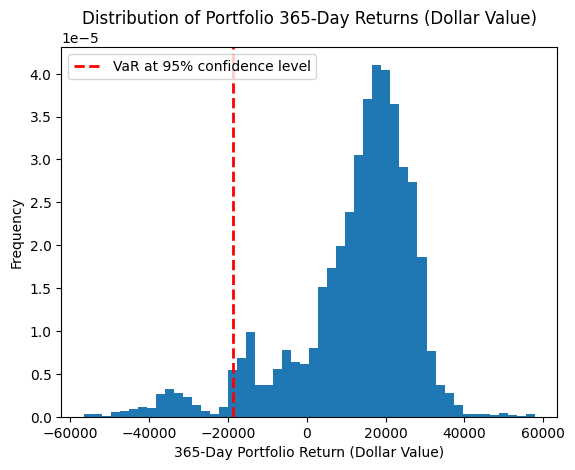

In [143]:
return_window = days
range_returns = historical_returns.rolling(window=return_window).sum()
range_returns = range_returns.dropna()
portfolio_value = 100000
range_returns_dollar = range_returns * portfolio_value

plt.hist(range_returns_dollar.dropna(), bins=50, density=True)
plt.xlabel(f'{return_window}-Day Portfolio Return (Dollar Value)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {return_window}-Day Returns (Dollar Value)')
plt.axvline(-VaR*portfolio_value, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()